# ML Training in XNAT

## 1. Library Imports

<!-- Warning (yellow) -->
<div style="background-color: #fff3cd; border-left: 4px solid #ffc107; padding: 12px; margin: 10px 0;">
<strong>⚠️ Warning</strong><br>
Your warning text here.
</div>

<!-- Success/Tip (green) -->
<div style="background-color: #d4edda; border-left: 4px solid #28a745; padding: 12px; margin: 10px 0;">
<strong>💡 Tip</strong><br>
Your tip text here.
</div>

<!-- Danger/Important (red) -->
<div style="background-color: #f8d7da; border-left: 4px solid #dc3545; padding: 12px; margin: 10px 0;">
<strong>🚨 Important</strong><br>
Critical information here.
</div>

<div style="background-color: #e7f3fe; border-left: 4px solid #2196F3; padding: 12px; margin: 10px 0;">
<strong>📌 Prerequisites</strong><br>
Before starting, ensure you have:
<ul>
<li>A reachable XNAT server URL</li>
<li>Credentials with appropriate project permissions</li>
<li><code>xnat</code> (xnatpy) and optionally <code>pydicom</code> installed</li>
</ul>
</div>

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import xnat
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from io import StringIO
from requests.auth import HTTPBasicAuth
from collections import Counter
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
from torchvision import models
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

from utils.torch_data_loading import load_dicom_data_with_logging
from models.resnet50 import ResNet

#### GPU Check
We also want to check that our notebook has access to the GPU resources in our instance.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Found available: {device}")

Found available: cuda


## Finding & Using Your XNAT Data

This notebook leverages the XNAT data heirarchy to supply data for model training and inference.

XNAT Data Heirarchy:
`/data/projects/<proj_ID>/experiments/<exp_label>/SCANS/<scan_label>/secondary/files`

Where:

- `<proj_ID>` – the XNAT project identifier (e.g. `00001` for this notebook)
- `<exp_label>` – the experiment / session label within that project
- `<scan_label>` – the individual scan series label within that experiment
- `secondary/files` – the folder containing the actual DICOM files for that scan

In this notebook, we load relavent data by pointing to our project root (`/data/projects/00001`) while helper functions walk the sub-directory structure to discover experiments, scans, and DICOM files automatically.

### Connecting to XNAT

Everything needed to start pulling data is readily available to you inside the notebook environment!

In [30]:
# Assign & Call Env variables  
host = os.environ['XNAT_HOST']
username = os.environ['XNAT_USER']
password = os.environ['XNAT_PASS']
connection = xnat.connect(
    host,
    user=os.environ['XNAT_USER'],
    password=os.environ['XNAT_PASS']
)

[WARNING] Detected a redirect from https://adapt-dev.embarklabs.ai to https://adapt-dev.embarklabs.ai:443/, using https://adapt-dev.embarklabs.ai:443/ from now on
[WARNING] Found an unsupported version (1.9.2.1), trying 1.7 compatible model builder
Exception in thread XNATpyKeepAliveThread:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py", line 787, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
               ^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/urllib3/connection.py", line 565, in getresponse
    httplib_response = super().getresponse()
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/http/client.py", line 1390, in getresponse
    response.begin()
  File "/opt/conda/lib/python3.11/http/client.py",

### Checking Connection & Data
To ensure we have successfully connected to XNAT and that we have access to our data, let's show a few key objects from our project.

In [9]:
# Check that our project exists
PROJECT_ID = "00001"
if PROJECT_ID not in connection.projects:
    raise ValueError(
        f"Project '{PROJECT_ID}' not found on this XNAT server."
        f"Available projects: {list(connection.projects.keys())}"
    )
project = connection.projects[PROJECT_ID]
print(f"{project.name} project found!")

# Check our experiments with our DICOMs exist.
print(f"Number of experiments found: {len(project.experiments)}")

INbreast Dataset project found!
Number of experiments found: 410


## Configuring Data Loading

After confirming our data is available, we now need to pull the data and supply it to our model in the correct format. 

We are also going to set a few key hyperparameters to be used throughout our training.

In [12]:
# Hyperparameters
BATCH_SIZE = 64

### Loading data 

Here we use pytorch's dataloader class to organize our data for downstream processing.

For clarity, much of the data loading code has been abstracted through the `load_dicom_data_with_logging` function. 

In [13]:
# Here we load the data into our dataloader class
dataloaders = load_dicom_data_with_logging("00001", batch_size=BATCH_SIZE)

# We then separate the data into training and validate subsets
images_train, labels_train = next(iter(dataloaders['train']))
images_val, labels_val = next(iter(dataloaders['val']))

# And finally we check the dimensions of the data 
print(f"Training batch shape: {images_train.shape}")
print(f"Validation batch shape: {images_val.shape}")

Training batch shape: torch.Size([64, 3, 224, 224])
Validation batch shape: torch.Size([64, 3, 224, 224])


#### Checking our Labels
Next, we double check we have the correct number of labels. 

Our images are labeled according to BI-RADS assessment. We should see 6 unique labels from our dataset.

In [17]:
ys = torch.tensor(dataloaders['train'].dataset.labels)
print("Unique train labels:", sorted(ys.unique().tolist()))

Unique train labels: [0, 1, 2, 3, 4, 5]


## Exploring Our Data

### Visualizations
Since we have pulled our data and organized it appropriately, let's pull a few examples and examine what our data looks like. 

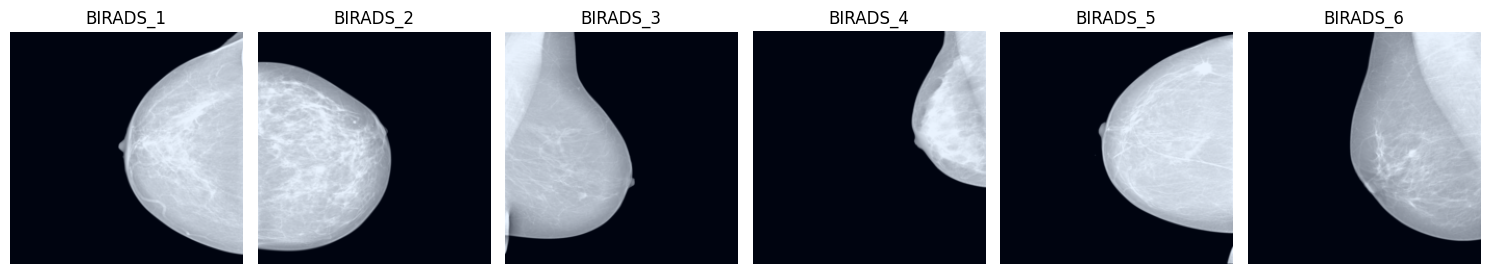

In [18]:
class_names = dataloaders['train'].dataset.classes
unique_labels = sorted(set(dataloaders['train'].dataset.labels))

fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for ax, class_name, label_value in zip(axes, class_names, unique_labels):
    found = False
    for images, labels in dataloaders['train']:
        mask = (labels == label_value).nonzero(as_tuple=True)[0]
        if mask.numel() > 0:
            idx = mask[0].item()
            image = images[idx].permute(1, 2, 0).numpy()
            image = (image - image.min()) / (image.max() - image.min())  # rescale 0–1
            ax.imshow(image)
            ax.set_title(class_name)
            ax.axis('off')
            found = True
            break
    if not found:
        ax.set_title(f"{class_name}\n(Not Found)")
        ax.axis('off')

plt.tight_layout()
plt.show()


### Exploring Our Data

Now that we have familizarized ourselves with our data, let's explore the dataset to uncover if there are any issues with our dataset. 

### Class balance and sampling

After inspecting our data we found that the class distribution is unbalanced.

Now we will use the per-class distribution in the training and validation splits to mitigate this imbalance. 

We will also verify how the `WeightedRandomSampler` in our PyTorch `DataLoader` helps compensate for this imbalance. 

Train class distribution:
  0 -> BIRADS_1: 54 samples
  1 -> BIRADS_2: 176 samples
  2 -> BIRADS_3: 19 samples
  3 -> BIRADS_4: 34 samples
  4 -> BIRADS_5: 39 samples
  5 -> BIRADS_6: 6 samples

Validation class distribution:
  0 -> BIRADS_1: 13 samples
  1 -> BIRADS_2: 44 samples
  2 -> BIRADS_3: 4 samples
  3 -> BIRADS_4: 9 samples
  4 -> BIRADS_5: 10 samples
  5 -> BIRADS_6: 2 samples


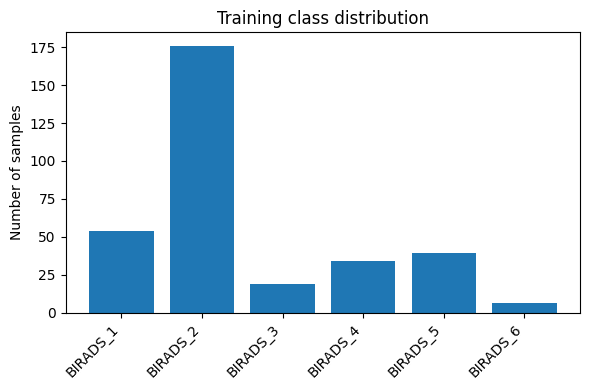

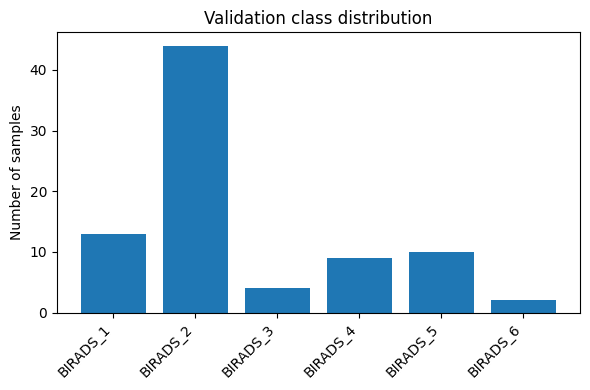

In [24]:
# --- 1. Raw label distribution (what's in the dataset) ---
train_labels = torch.tensor(dataloaders['train'].dataset.labels)
val_labels = torch.tensor(dataloaders['val'].dataset.labels)
class_names = dataloaders['train'].dataset.classes

train_counts = Counter(train_labels.tolist())
val_counts = Counter(val_labels.tolist())

print("Train class distribution:")
for idx, name in enumerate(class_names):
    print(f"  {idx} -> {name}: {train_counts.get(idx, 0)} samples")

print("\nValidation class distribution:")
for idx, name in enumerate(class_names):
    print(f"  {idx} -> {name}: {val_counts.get(idx, 0)} samples")

def plot_class_distribution(counts, class_names, title):
    idxs = range(len(class_names))
    values = [counts.get(i, 0) for i in idxs]
    labels = [class_names[i] for i in idxs]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of samples")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_counts, class_names, "Training class distribution")
plot_class_distribution(val_counts, class_names, "Validation class distribution")

## Mitigating the Class Imbalance


We have now explored the class imbalance in our dataset, now let's ammend our Sampler in our Pytorch DataLoader in order to pull classes for training proportionally. 


Sampler mean weight per class:
  0 -> BIRADS_1: mean weight = 0.0185
  1 -> BIRADS_2: mean weight = 0.0057
  2 -> BIRADS_3: mean weight = 0.0526
  3 -> BIRADS_4: mean weight = 0.0294
  4 -> BIRADS_5: mean weight = 0.0256
  5 -> BIRADS_6: mean weight = 0.1667


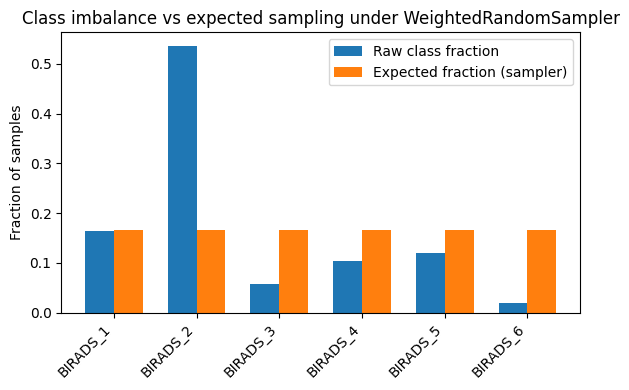

In [25]:
# --- 2. Sampler weights and expected sampling distribution ---
sampler = dataloaders['train'].sampler
if hasattr(sampler, "weights"):
    w = sampler.weights.detach().cpu().numpy()
    y_np = train_labels.numpy()

    print("\nSampler mean weight per class:")
    for idx, name in enumerate(class_names):
        mask = (y_np == idx)
        if mask.any():
            mean_w = float(w[mask].mean())
            print(f"  {idx} -> {name}: mean weight = {mean_w:.4f}")

    # Compute raw fraction vs expected fraction under the sampler
    total_samples = len(y_np)
    total_weight = w.sum()

    raw_frac = []
    expected_frac = []

    for idx, name in enumerate(class_names):
        mask = (y_np == idx)
        n_raw = mask.sum()
        raw_frac.append(n_raw / total_samples if total_samples > 0 else 0.0)

        w_sum = w[mask].sum()
        expected_frac.append(w_sum / total_weight if total_weight > 0 else 0.0)

    # Plot: raw vs expected sampling fraction
    idxs = np.arange(len(class_names))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(idxs - width/2, raw_frac, width=width, label="Raw class fraction")
    plt.bar(idxs + width/2, expected_frac, width=width, label="Expected fraction (sampler)")
    plt.xticks(idxs, class_names, rotation=45, ha="right")
    plt.ylabel("Fraction of samples")
    plt.title("Class imbalance vs expected sampling under WeightedRandomSampler")
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("\nNo WeightedRandomSampler detected on the training DataLoader.")


## 2. ResNet-50 training and validation

Here we fine-tune a torchvision `resnet50` model on the DICOM data. The inputs are already
normalized to ImageNet statistics in the data-loading pipeline, so they are compatible with
the standard ImageNet-pretrained backbone.


In [26]:
num_classes = len(dataloaders['train'].dataset.classes)
print(f"Detected {num_classes} classes:", dataloaders['train'].dataset.classes)

# Load an ImageNet-pretrained ResNet-50 and replace the final FC layer
try:
    weights = models.ResNet50_Weights.IMAGENET1K_V2
    model = models.resnet50(weights=weights)
except AttributeError:
    # Fallback for older torchvision versions
    model = models.resnet50(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2)

num_epochs = 5  # adjust as needed for your demo

history = {
    "train_loss": [],
    "val_loss": [],
    "train_err": [],
    "val_err": [],
}

for epoch in range(num_epochs):
    # ----- Train -----
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for xb, yb in dataloaders["train"]:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        running_total += yb.size(0)

    epoch_train_loss = running_loss / running_total
    epoch_train_err = 1.0 - (running_correct / running_total)

    # ----- Validation -----
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    val_running_total = 0

    with torch.no_grad():
        for xb, yb in dataloaders["val"]:
            xb = xb.to(device)
            yb = yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)

            val_running_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            val_running_correct += (preds == yb).sum().item()
            val_running_total += yb.size(0)

    epoch_val_loss = val_running_loss / val_running_total
    epoch_val_err = 1.0 - (val_running_correct / val_running_total)

    history["train_loss"].append(epoch_train_loss)
    history["val_loss"].append(epoch_val_loss)
    history["train_err"].append(epoch_train_err)
    history["val_err"].append(epoch_val_err)

    scheduler.step(epoch_val_loss)

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"train_loss={epoch_train_loss:.4f}, val_loss={epoch_val_loss:.4f}, "
        f"train_err={epoch_train_err:.4f}, val_err={epoch_val_err:.4f}"
    )


Detected 6 classes: ['BIRADS_1', 'BIRADS_2', 'BIRADS_3', 'BIRADS_4', 'BIRADS_5', 'BIRADS_6']


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/admin/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


Epoch 1/5 | train_loss=1.7273, val_loss=1.7227, train_err=0.6311, val_err=0.5366
Epoch 2/5 | train_loss=1.5027, val_loss=1.7136, train_err=0.3476, val_err=0.6341
Epoch 3/5 | train_loss=1.2181, val_loss=1.6981, train_err=0.1616, val_err=0.6341
Epoch 4/5 | train_loss=0.9319, val_loss=1.6924, train_err=0.1280, val_err=0.6951
Epoch 5/5 | train_loss=0.7212, val_loss=1.6835, train_err=0.0640, val_err=0.7439


## 3. Evaluation: metrics, curves, and confusion matrix

We now evaluate the fine-tuned model on the validation split using:
- Macro-averaged F1-score, precision, and recall
- Per-class classification report
- Loss and error-rate curves over epochs
- Confusion matrix with BI-RADS class labels on each axis


Macro precision: 0.1537
Macro recall:    0.1916
Macro F1-score:  0.1224

Per-class classification report (validation):
              precision    recall  f1-score   support

    BIRADS_1       0.20      0.08      0.11        13
    BIRADS_2       0.57      0.27      0.37        44
    BIRADS_3       0.00      0.00      0.00         4
    BIRADS_4       0.00      0.00      0.00         9
    BIRADS_5       0.15      0.80      0.25        10
    BIRADS_6       0.00      0.00      0.00         2

    accuracy                           0.26        82
   macro avg       0.15      0.19      0.12        82
weighted avg       0.36      0.26      0.25        82



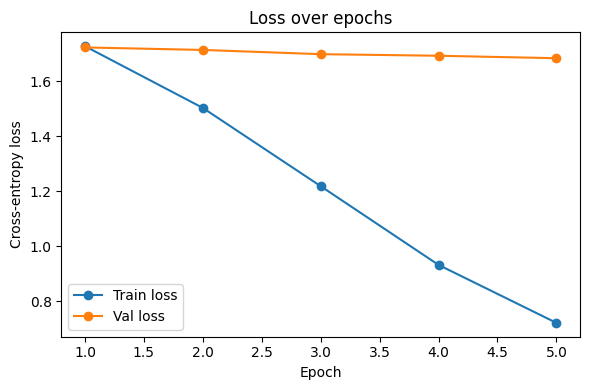

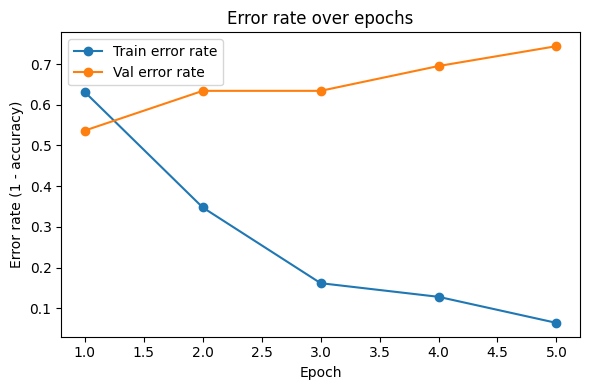

In [28]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for xb, yb in dataloaders["val"]:
        xb = xb.to(device)
        outputs = model(xb)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

class_names = dataloaders["val"].dataset.classes

macro_precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
macro_recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
macro_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

print(f"Macro precision: {macro_precision:.4f}")
print(f"Macro recall:    {macro_recall:.4f}")
print(f"Macro F1-score:  {macro_f1:.4f}\n")

print("Per-class classification report (validation):")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

# ---- Loss and error-rate curves ----
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_loss"], marker="o", label="Train loss")
plt.plot(epochs, history["val_loss"], marker="o", label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("Loss over epochs")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(epochs, history["train_err"], marker="o", label="Train error rate")
plt.plot(epochs, history["val_err"], marker="o", label="Val error rate")
plt.xlabel("Epoch")
plt.ylabel("Error rate (1 - accuracy)")
plt.title("Error rate over epochs")
plt.legend()
plt.tight_layout()
plt.show()

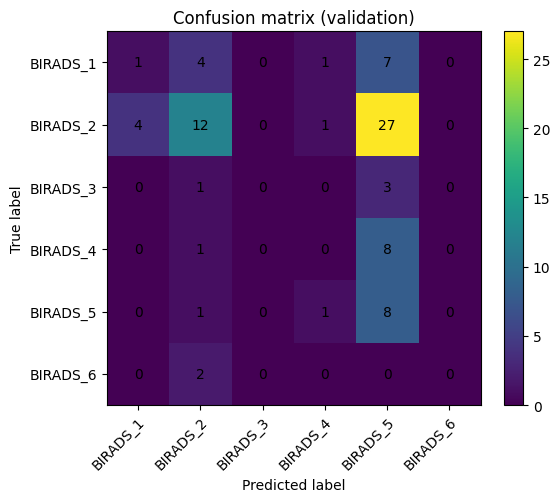

In [29]:
# ---- Confusion matrix ----
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(class_names))))

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel="True label",
    xlabel="Predicted label",
    title="Confusion matrix (validation)",
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate each cell with the count
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j,
            i,
            int(cm[i, j]),
            ha="center",
            va="center",
        )

plt.tight_layout()
plt.show()